## Load Dependancies

In [25]:
import geopandas as gpd
import pandas as pd

from shapely.geometry import Point

## Load US Counties File

In [2]:
uscounties = gpd.read_file("data/UScounties/UScounties.shp")

In [3]:
uscounties = uscounties[(uscounties["STATE_NAME"]!="Alaska") & (uscounties["STATE_NAME"]!="Hawaii")]
uscounties["FIPS"] = uscounties["FIPS"].astype(int)
uscounties

,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,geometry
0,Lake of the Woods,Minnesota,27,077,27077,"POLYGON ((-95.34283 48.54668, -95.34105 48.715..."
1,Ferry,Washington,53,019,53019,"POLYGON ((-118.85163 47.94956, -118.84846 48.4..."
2,Stevens,Washington,53,065,53065,"POLYGON ((-117.43883 48.04412, -117.54219 48.0..."
3,Okanogan,Washington,53,047,53047,"POLYGON ((-118.97209 47.93915, -118.97406 47.9..."
4,Pend Oreille,Washington,53,051,53051,"POLYGON ((-117.43858 48.99992, -117.03205 48.9..."
...,...,...,...,...,...,...
3104,LaGrange,Indiana,18,087,18087,"POLYGON ((-85.66327 41.53557, -85.65946 41.762..."
3105,Steuben,Indiana,18,151,18151,"POLYGON ((-84.79137 41.53049, -85.19715 41.537..."
3132,Pittsylvania,Virginia,51,143,51143,"POLYGON ((-79.71720 36.54803, -79.64135 36.846..."
3133,Danville,Virginia,51,590,51590,"POLYGON ((-79.51977 36.59777, -79.50138 36.621..."


## Preprocess Airports

In [4]:
state_abbrev_to_name = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

state_codes = {
    'WA': '53', 'DE': '10', 'DC': '11', 'WI': '55', 'WV': '54', 'HI': '15',
    'FL': '12', 'WY': '56', 'PR': '72', 'NJ': '34', 'NM': '35', 'TX': '48',
    'LA': '22', 'NC': '37', 'ND': '38', 'NE': '31', 'TN': '47', 'NY': '36',
    'PA': '42', 'AK': '02', 'NV': '32', 'NH': '33', 'VA': '51', 'CO': '08',
    'CA': '06', 'AL': '01', 'AR': '05', 'VT': '50', 'IL': '17', 'GA': '13',
    'IN': '18', 'IA': '19', 'MA': '25', 'AZ': '04', 'ID': '16', 'CT': '09',
    'ME': '23', 'MD': '24', 'OK': '40', 'OH': '39', 'UT': '49', 'MO': '29',
    'MN': '27', 'MI': '26', 'RI': '44', 'KS': '20', 'MT': '30', 'MS': '28',
    'SC': '45', 'KY': '21', 'OR': '41', 'SD': '46'
}

In [5]:
airports = pd.read_csv("data/airports.csv")
airports = airports[(airports["iso_country"]=="US") & (airports["iso_region"] != "US-AK") & (airports["iso_region"] != "US-HI")]
airports = airports[(airports["type"]=="large_airport") | (airports["type"]=="medium_airport")]

military_airports = airports[(airports["name"].str.contains("Army")) | (airports["name"].str.contains("Navy")) | (airports["name"].str.contains("Air Force"))]
large_airports = airports[~(airports["name"].str.contains("Army")) & ~(airports["name"].str.contains("Navy")) & ~(airports["name"].str.contains("Air Force"))]
large_airports = airports[airports["type"]=="large_airport"]

large_airports["geometry"] = [Point(x,y) for x,y in zip(large_airports["longitude_deg"],large_airports["latitude_deg"])]
military_airports["geometry"] = [Point(x,y) for x,y in zip(military_airports["longitude_deg"],military_airports["latitude_deg"])]

large_airports = gpd.GeoDataFrame(large_airports,crs="EPSG:4326")
military_airports = gpd.GeoDataFrame(military_airports,crs="EPSG:4326")

military_airports["is_military"] = [True] * len(military_airports["name"])
large_airports["is_military"] = [False] * len(large_airports["name"])

airports = pd.concat([military_airports,large_airports])

airports["state"] = [state_abbrev_to_name[iso_region[3:]] for iso_region in airports["iso_region"]]
airports["state_fips"] = [state_codes[iso_region[3:]] for iso_region in airports["iso_region"]]

airports = airports[["ident","name","elevation_ft","state","state_fips","scheduled_service","keywords","is_military","geometry"]]

airports

c:\users\rish\python virtual environments\pyenv\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
c:\users\rish\python virtual environments\pyenv\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,ident,name,elevation_ft,state,state_fips,scheduled_service,keywords,is_military,geometry
29105,KAPG,Phillips Army Air Field,57.0,Maryland,24,no,NaN,True,POINT (-76.16880 39.46620)
29174,KBAB,Beale Air Force Base,113.0,California,06,no,NaN,True,POINT (-121.43700 39.13610)
29175,KBAD,Barksdale Air Force Base,166.0,Louisiana,22,no,NaN,True,POINT (-93.66270 32.50180)
29225,KBIF,Biggs Army Air Field (Fort Bliss),3946.0,Texas,48,no,Fort Bliss,True,POINT (-106.38000 31.84950)
29231,KBIX,Keesler Air Force Base,33.0,Mississippi,28,no,NaN,True,POINT (-88.92440 30.41040)
...,...,...,...,...,...,...,...,...,...
33191,KTUS,Tucson International Airport / Morris Air Nati...,2643.0,Arizona,04,yes,"tucson, tucson international, morris angb",False,POINT (-110.93805 32.11500)
33207,KTYS,McGhee Tyson Airport,981.0,Tennessee,47,yes,NaN,False,POINT (-83.99400 35.81100)
33289,KVBG,Vandenberg Air Force Base,369.0,California,06,no,NaN,False,POINT (-120.58400 34.73730)
33317,KVPS,Destin-Ft Walton Beach Airport,87.0,Florida,12,yes,Eglin AFB,False,POINT (-86.52540 30.48320)


## Save Airports as Shape File

In [6]:
airports.to_file("Data/airports/airports.shp")

c:\users\rish\python virtual environments\pyenv\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  """Entry point for launching an IPython kernel.


## Preprocess Vaccine Locations File

In [7]:
vaccine_locs = pd.read_csv("data/vaccine_locations.csv")

vaccine_locs["geometry"] = [Point(x,y) for x,y in zip(vaccine_locs["Longitude"],vaccine_locs["Latitude"])]
vaccine_locs = gpd.GeoDataFrame(vaccine_locs,crs="EPSG:4326")

vaccine_locs

,SiteID,Latitude,Longitude,geometry
0,1,18.013291,-66.614490,POINT (-66.61449 18.01329)
1,2,18.178309,-66.111070,POINT (-66.11107 18.17831)
2,3,18.179246,-66.113423,POINT (-66.11342 18.17925)
3,4,18.179246,-66.113423,POINT (-66.11342 18.17925)
4,5,18.180752,-66.112215,POINT (-66.11222 18.18075)
...,...,...,...,...
11579,11580,37.789000,-103.530000,POINT (-103.53000 37.78900)
11580,11581,30.812000,-102.472000,POINT (-102.47200 30.81200)
11581,11582,39.028000,-102.837000,POINT (-102.83700 39.02800)
11582,11583,41.099000,-100.616000,POINT (-100.61600 41.09900)


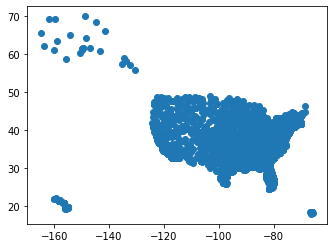

In [10]:
vaccine_locs.plot()

In [11]:
joined_vaccine_us_counties = gpd.sjoin(vaccine_locs,uscounties,predicate='within')

In [12]:
joined_vaccine_us_counties = joined_vaccine_us_counties[["SiteID","Latitude","Longitude","geometry","NAME","STATE_NAME","STATE_FIPS","CNTY_FIPS","FIPS"]]

In [13]:
joined_vaccine_us_counties

,SiteID,Latitude,Longitude,geometry,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS
110,111,25.092723,-80.442251,POINT (-80.44225 25.09272),Monroe,Florida,12,087,12087
111,112,25.477291,-80.449200,POINT (-80.44920 25.47729),Miami-Dade,Florida,12,086,12086
112,113,25.480468,-80.463603,POINT (-80.46360 25.48047),Miami-Dade,Florida,12,086,12086
113,114,25.494244,-80.432291,POINT (-80.43229 25.49424),Miami-Dade,Florida,12,086,12086
114,115,25.499912,-80.446542,POINT (-80.44654 25.49991),Miami-Dade,Florida,12,086,12086
...,...,...,...,...,...,...,...,...,...
11579,11580,37.789000,-103.530000,POINT (-103.53000 37.78900),Otero,Colorado,08,089,8089
11580,11581,30.812000,-102.472000,POINT (-102.47200 30.81200),Pecos,Texas,48,371,48371
11581,11582,39.028000,-102.837000,POINT (-102.83700 39.02800),Cheyenne,Colorado,08,017,8017
11582,11583,41.099000,-100.616000,POINT (-100.61600 41.09900),Lincoln,Nebraska,31,111,31111


## Save Vaccine Locations to Shape File

In [14]:
joined_vaccine_us_counties.to_file("Data/vaccine_locations/vaccine_locations.shp")

## Cast FIPS Column in covid-us-counties as int

In [52]:
covid_cases = pd.read_csv("data/covid-us-counties.csv")

In [53]:
covid_cases = covid_cases[~covid_cases["fips"].isna()]
covid_cases["fips"] = covid_cases["fips"].astype(int)
covid_cases = covid_cases[covid_cases["date"]=="2020-10-08"]
covid_cases

,date,county,state,fips,cases,deaths
608941,2020-10-08,Autauga,Alabama,1001,1863,28.0
608942,2020-10-08,Baldwin,Alabama,1003,6141,64.0
608943,2020-10-08,Barbour,Alabama,1005,927,9.0
608944,2020-10-08,Bibb,Alabama,1007,708,12.0
608945,2020-10-08,Blount,Alabama,1009,1681,16.0
...,...,...,...,...,...,...
612178,2020-10-08,Sweetwater,Wyoming,56037,382,2.0
612179,2020-10-08,Teton,Wyoming,56039,645,1.0
612180,2020-10-08,Uinta,Wyoming,56041,373,2.0
612181,2020-10-08,Washakie,Wyoming,56043,122,6.0


In [54]:
covid_cases.to_csv("data/covid_cases_october.csv")

## Get Vaccination Rate by County

In [17]:
vaccine_data_file = "data/COVID-19_Vaccinations_in_the_United_States_County.csv"
vac_by_county = pd.read_csv(vaccine_data_file)
vac_by_county

c:\users\rish\python virtual environments\pyenv\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Date,FIPS,MMWR_week,Recip_County,Recip_State,Series_Complete_Pop_Pct,Series_Complete_Yes,Series_Complete_12Plus,Series_Complete_12PlusPop_Pct,Series_Complete_18Plus,...,SVI_CTGY,Series_Complete_Pop_Pct_SVI,Series_Complete_12PlusPop_Pct_SVI,Series_Complete_18PlusPop_Pct_SVI,Series_Complete_65PlusPop_Pct_SVI,Metro_status,Series_Complete_Pop_Pct_UR_Equity,Series_Complete_12PlusPop_Pct_UR_Equity,Series_Complete_18PlusPop_Pct_UR_Equity,Series_Complete_65PlusPop_Pct_UR_Equity
0,10/09/2021,04025,40,Yavapai County,AZ,39.9,93695,93690.0,44.4,90975,...,C,10.0,11.0,11.0,11.0,Metro,2.0,3.0,3.0,3.0
1,10/09/2021,21009,40,Barren County,KY,40.5,17899,17899.0,47.9,17034,...,D,15.0,15.0,16.0,16.0,Non-metro,7.0,7.0,8.0,8.0
2,10/09/2021,21007,40,Ballard County,KY,32.5,2560,2560.0,37.3,2487,...,B,6.0,6.0,6.0,7.0,Non-metro,6.0,6.0,6.0,7.0
3,10/09/2021,21091,40,Hancock County,KY,53.1,4635,4635.0,63.2,4365,...,B,8.0,8.0,8.0,8.0,Metro,4.0,4.0,4.0,4.0
4,10/09/2021,46023,40,Charles Mix County,SD,42.3,3927,3926.0,53.4,3656,...,C,11.0,12.0,12.0,12.0,Non-metro,7.0,8.0,8.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987881,12/13/2020,37199,51,Yancey County,NC,0.0,0,0.0,0.0,0,...,C,NaN,NaN,NaN,NaN,Non-metro,NaN,NaN,NaN,NaN
987882,12/13/2020,51183,51,Sussex County,VA,0.0,0,0.0,0.0,0,...,D,NaN,NaN,NaN,NaN,Metro,NaN,NaN,NaN,NaN
987883,12/13/2020,5115,51,Pope County,AR,0.0,0,0.0,0.0,0,...,D,NaN,NaN,NaN,NaN,Non-metro,NaN,NaN,NaN,NaN
987884,12/13/2020,37005,51,Alleghany County,NC,0.0,0,0.0,0.0,0,...,C,NaN,NaN,NaN,NaN,Non-metro,NaN,NaN,NaN,NaN


In [24]:
vac_by_county = vac_by_county[vac_by_county["FIPS"]!="UNK"]
vac_by_county["FIPS"] = vac_by_county["FIPS"].astype(int)

vac_by_county = vac_by_county[vac_by_county["Date"]=="10/08/2021"]
vac_by_county = vac_by_county[["Recip_County","Recip_State","FIPS","Series_Complete_Pop_Pct","Series_Complete_Yes"]]

vac_by_county

c:\users\rish\python virtual environments\pyenv\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


,Recip_County,Recip_State,FIPS,Series_Complete_Pop_Pct,Series_Complete_Yes
3282,Marshall County,IN,18099,40.2,18592
3283,Columbia County,FL,12023,37.1,26598
3284,Hidalgo County,NM,35023,43.1,1808
3285,Essex County,MA,25009,64.0,504722
3286,Hennepin County,MN,27053,63.6,805271
...,...,...,...,...,...
6559,Gilmer County,WV,54021,40.5,3168
6560,Robertson County,KY,21201,34.2,721
6561,Clark County,KY,21049,51.6,18701
6562,Wadena County,MN,27159,42.4,5801


In [49]:
vac_by_county.to_csv("data/vaccination_rate_by_county.csv")

## County Demographic Data

In [39]:
demographics = pd.read_csv('data/us_county_demographic_data.csv', header=1)
demographics

,id,Geographic Area Name,!!Total:,!!Total:!!Population of one race:,!!Total:!!Population of one race:!!White alone,!!Total:!!Population of one race:!!Black or African American alone,!!Total:!!Population of one race:!!American Indian and Alaska Native alone,!!Total:!!Population of one race:!!Asian alone,!!Total:!!Population of one race:!!Native Hawaiian and Other Pacific Islander alone,!!Total:!!Population of one race:!!Some Other Race alone,...,!!Total:!!Population of two or more races:!!Population of four races:!!American Indian and Alaska Native; Asian; Native Hawaiian and Other Pacific Islander; Some Other Race,!!Total:!!Population of two or more races:!!Population of five races:,!!Total:!!Population of two or more races:!!Population of five races:!!White; Black or African American; American Indian and Alaska Native; Asian; Native Hawaiian and Other Pacific Islander,!!Total:!!Population of two or more races:!!Population of five races:!!White; Black or African American; American Indian and Alaska Native; Asian; Some Other Race,!!Total:!!Population of two or more races:!!Population of five races:!!White; Black or African American; American Indian and Alaska Native; Native Hawaiian and Other Pacific Islander; Some Other Race,!!Total:!!Population of two or more races:!!Population of five races:!!White; Black or African American; Asian; Native Hawaiian and Other Pacific Islander; Some Other Race,!!Total:!!Population of two or more races:!!Population of five races:!!White; American Indian and Alaska Native; Asian; Native Hawaiian and Other Pacific Islander; Some Other Race,!!Total:!!Population of two or more races:!!Population of five races:!!Black or African American; American Indian and Alaska Native; Asian; Native Hawaiian and Other Pacific Islander; Some Other Race,!!Total:!!Population of two or more races:!!Population of six races:,!!Total:!!Population of two or more races:!!Population of six races:!!White; Black or African American; American Indian and Alaska Native; Asian; Native Hawaiian and Other Pacific Islander; Some Other Race
0,0500000US01001,"Autauga County, Alabama",58805,55648,42160,11445,217,881,35,910,...,0,2,2,0,0,0,0,0,0,0
1,0500000US01003,"Baldwin County, Alabama",231767,216743,189399,18217,1582,2067,143,5335,...,0,0,0,0,0,0,0,0,0,0
2,0500000US01005,"Barbour County, Alabama",25223,24523,11317,11933,116,117,1,1039,...,0,2,2,0,0,0,0,0,0,0
3,0500000US01007,"Bibb County, Alabama",22293,21534,16555,4413,60,32,9,465,...,0,0,0,0,0,0,0,0,0,0
4,0500000US01009,"Blount County, Alabama",59134,55478,50663,845,337,178,24,3431,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3217,0500000US72147,"Vieques Municipio, Puerto Rico",8249,6127,1551,1256,86,7,1,3226,...,0,0,0,0,0,0,0,0,0,0
3218,0500000US72149,"Villalba Municipio, Puerto Rico",22093,11151,3429,1380,130,10,0,6202,...,0,0,0,0,0,0,0,0,0,0
3219,0500000US72151,"Yabucoa Municipio, Puerto Rico",30426,19720,5028,2941,199,8,7,11537,...,0,0,0,0,0,0,0,0,0,0
3220,0500000US72153,"Yauco Municipio, Puerto Rico",34172,18958,7312,1617,209,25,2,9793,...,0,0,0,0,0,0,0,0,0,0


In [41]:
demographics['FIPS'] = demographics['id'].str[9:]
# demographics.columns
demographics = demographics[demographics["FIPS"]!=""]
demographics["FIPS"] = demographics["FIPS"].astype(int)
demographics['Minority_Pct'] = (-1 * (demographics[' !!Total:!!Population of one race:!!White alone'] / demographics[' !!Total:'])) + 1
demographics['Minority_Pct']

c:\users\rish\python virtual environments\pyenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
c:\users\rish\python virtual environments\pyenv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


0       0.283054
1       0.182804
2       0.551322
3       0.257390
4       0.143251
          ...   
3216    0.815452
3217    0.811977
3218    0.844792
3219    0.834747
3220    0.786024
Name: Minority_Pct, Length: 3221, dtype: float64

In [42]:
cols = ['FIPS','Minority_Pct']
demographics = demographics[cols]
demographics

,FIPS,Minority_Pct
0,1001,0.283054
1,1003,0.182804
2,1005,0.551322
3,1007,0.257390
4,1009,0.143251
...,...,...
3216,72145,0.815452
3217,72147,0.811977
3218,72149,0.844792
3219,72151,0.834747


## Population Data

In [46]:
pop_df = pd.read_csv('data/population_data.csv')
pop_df['FIPS'] = ((pop_df['STATE'] * 1000) + pop_df['COUNTY'])
pop_df['FIPS'] = pop_df['FIPS'].astype(int)
pop_columns = ['FIPS','POPESTIMATE2019']
pop_df = pop_df[pop_columns]
pop_df

,FIPS,POPESTIMATE2019
0,1000,4903185
1,1001,55869
2,1003,223234
3,1005,24686
4,1007,22394
...,...,...
3188,56037,42343
3189,56039,23464
3190,56041,20226
3191,56043,7805


In [47]:
pop_df = pop_df.merge(demographics,on="FIPS")
pop_df

,FIPS,POPESTIMATE2019,Minority_Pct
0,1001,55869,0.283054
1,1003,223234,0.182804
2,1005,24686,0.551322
3,1007,22394,0.257390
4,1009,57826,0.143251
...,...,...,...
3136,56037,42343,0.186483
3137,56039,23464,0.176975
3138,56041,20226,0.119462
3139,56043,7805,0.141184


In [50]:
pop_df.to_csv("data/population_minmaj_county.csv")